# Part 1 — Velocity Field: Fractional-Step Navier–Stokes Solver

This notebook computes the 2D velocity and pressure fields for the counter-current methane–air combustion configuration using a fractional-step (projection) method.

It reuses:
- `config.py` for physical and numerical parameters
- `grid.py` for the grid definition

The solver and boundary conditions are the same as in the original M2 notebook:
- velocity is stored as 1D vectors of size `Nx*Nx`
- we use the index mapping `k(i, j) = i + j * Nx`
- fractional-step:
    - compute intermediate velocities (without pressure)
    - solve the Poisson equation `A p = b`
    - correct velocities with the pressure gradient

At the end, we plot velocity streamlines and pressure fields at three different times.


In [14]:
import os
import sys

project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.append(src_path)

print("Added to PYTHONPATH:", src_path)


import numpy as np
import matplotlib.pyplot as plt

from counterflow.config import default_params
from counterflow.grid import create_grid, allocate_velocity_fields
from counterflow.navier_stokes import V0_cond, fractional_step


Added to PYTHONPATH: /Users/emma.grospellier/Final-project-M2-Combustion-of-methane-in-a-countercurrent-configuration/src


In [26]:
# Load parameters
params = default_params()

Nx = params["Nx"]
Lx = params["Lx"]
nu = params["nu"]
rho = params["rho"]
dt = params["dt"]
Nt = params["Nt"]

print("Simulation parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

# Build grid
x, y, dx, dy = create_grid(Lx=Lx, Nx=Nx)
print("Grid created:", x.shape, y.shape, "dx =", dx, "dy =", dy)

Simulation parameters:
  rho: 1.1614
  nu: 1.5e-05
  D: 1.5e-05
  cp: 1200
  Lx: 0.002
  Ly: 0.002
  Nx: 50
  Ny: 50
  Tf: 0.01
  Nt: 3000
  dt: 3.334444814938313e-06
Grid created: (50, 50) (50, 50) dx = 4.0816326530612245e-05 dy = 4.0816326530612245e-05


In [16]:
# IC
U0 = np.zeros(Nx * Nx)
V0 = V0_cond(Nx)      
P0 = np.zeros(Nx * Nx)

In [32]:
print("Running fractional-step simulation…")
p, u, v = fractional_step(U0=U0, V0=V0, P0=P0,dt=dt,dx=dx,nu=nu,Nt=Nt,Nx=Nx,rho=rho)
print("Simulation finished.")

Running fractional-step simulation…
Condition number: 34607994010.898506
Simulation finished.


In [34]:
# reshape (Nx*Nx, Nt)  →  (Nx, Nx, Nt)
U = u.reshape(Nx, Nx, Nt)
V = v.reshape(Nx, Nx, Nt)
P = p.reshape(Nx, Nx, Nt)

# grid for streamplot
x_vec = np.linspace(0, Nx, Nx)
y_vec = np.linspace(0, Nx, Nx)
X, Y = np.meshgrid(x_vec, y_vec)

In [35]:
print("shape v =", v.shape)


shape v = (2500, 3000)


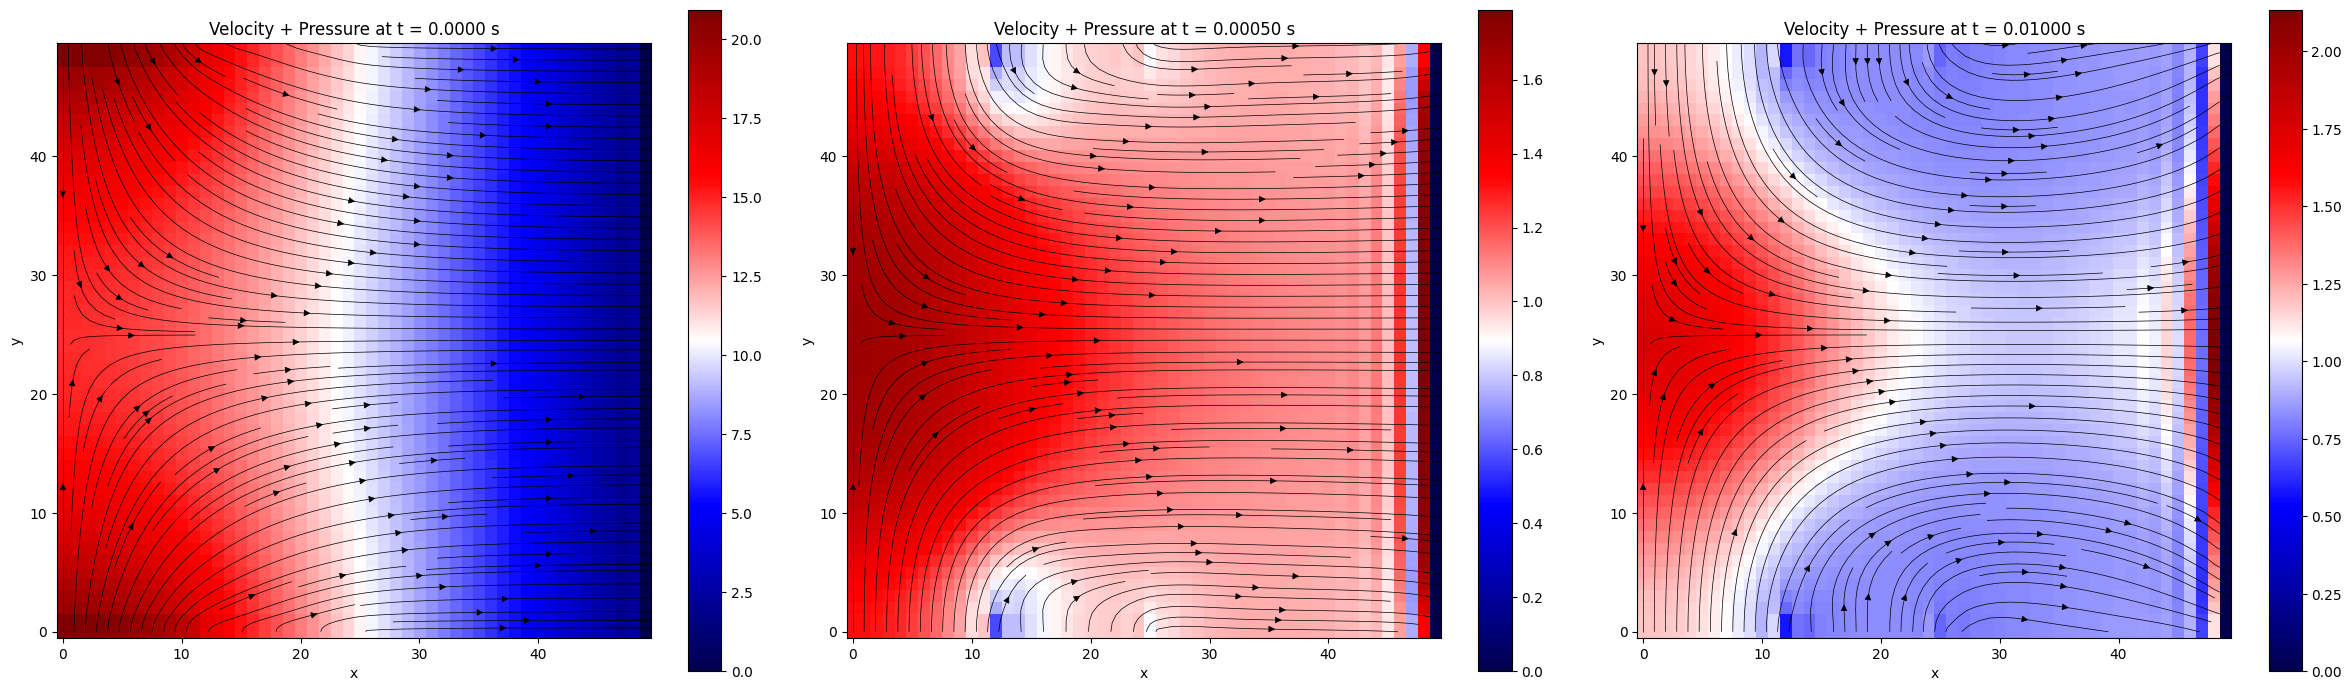

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

# Times to show
t1 = 5                          # early step
t2 = (Nt - 1) // 20             # mid
t3 = Nt - 1                     # final

times = [t1, t2, t3]
titles = [f"t = {t1*dt:.4f} s",f"t = {t2*dt:.5f} s",f"t = {t3*dt:.5f} s"]

for ax, ti, title in zip(axs, times, titles):
    ax.streamplot(x_vec, y_vec,U[:, :, ti], V[:, :, ti],color='black',density=1.8,linewidth=0.5)
    im = ax.imshow(P[:, :, ti],cmap='seismic',origin='lower',interpolation='nearest')
    ax.set_title(f"Velocity + Pressure at {title}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


In [37]:
print("shape v =", v.shape)


shape v = (2500, 3000)


In [20]:
print("Field statistics ")
print(f"<u> = {np.mean(u[:, -1]):.4e}")
print(f"<v> = {np.mean(v[:, -1]):.4e}")
print(f"<p> = {np.mean(p[:, -1]):.4e}")

print("Velocity magnitude (L2 norm):")
vel_norm = np.sqrt(np.mean(u[:, -1]**2 + v[:, -1]**2))
print(f"|V|^2 = {vel_norm:.4e}")


Field statistics 
<u> = 4.6100e-01
<v> = -1.7664e-08
<p> = 1.0314e+00
Velocity magnitude (L2 norm):
|V|^2 = 6.9310e-01


The velocity field exhibits an intense injection zone at the top and bottom, forming a central recirculation zone characteristic of counter-current flow. The pressure gradually equalizes and becomes almost stationary.

In [38]:
print("shape v =", v.shape)


shape v = (2500, 3000)


In [39]:
#save data
np.save("../data/u.npy", u)
np.save("../data/v.npy", v)
np.save("../data/p.npy", p)
np.save("../data/x.npy", x)
np.save("../data/y.npy", y)
np.save("../data/dx.npy", dx)
np.save("../data/dt.npy", dt)
np.savetxt("../data/Nt.txt", [Nt])
np.savetxt("../data/rho.txt", [rho])
np.savetxt("../data/nu.txt", [nu])